In [72]:
%matplotlib inline
#%load_ext autoreload
#%autoreload 2
%reload_ext autoreload
import numpy as np
import matplotlib.pyplot as plt
import math, sys, os
import pandas as pd
from random import random as rand
from random import randint

## K Minimum Value estimator for Approximate distinct Values

K Miminum Value Distinct Value Estimation works by assuming that you can design a hash function that will spread your data *uniformly* across a closed interval [0,1].  If this is so, we can estimate the average spacing between each of our hashed datapoints with the first order statistic S<sub>1</sub>, by DV_hat = 1 / S<sub>1</sub>.

In [48]:


class MVEstimator:
    
    def __init__(self):
        self.min_value = None
    
    def update(self,v):
        if self.min_value == None:
            self.min_value = v
        else:
            self.min_value = min(self.min_value,v)
    
    def estimate_DV(self):
        return 1 / self.min_value


MV = MVEstimator()
for i in range(10000):
    MV.update(rand())

print MV.estimate_DV()

2381.74164606


Now, since this estimator is derived from a single value, S<sub>1</sub>, the variance of this estimator is going to be equal to the variance of S<sub>1</sub>.  A straitforward way to reduce variance of this estimator is to change from using S<sub>1</sub>, to using S<sub>k</sub>, the k-th order statistic.  

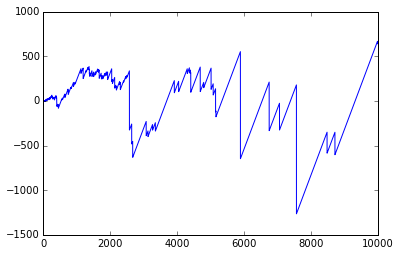

In [66]:
import heapq

class KMV:
    
    def __init__(self, k):
        self._heap = []
        self.count = 0
        self.k = k
    
    def show(self):
        return sorted([-1 * x for x in self._heap])
        
    def total_seen(self):
        return self.count
    
    def size(self):
        return len(self._heap)
    
    def __heappush(self, v):
        """
        storing the values as negatives, to make a max-heap
        """
        heapq.heappush(self._heap, v)
        self.count += 1
        
    def __heappop(self):
        return -1 * heapq.heappop(self._heap)
    
    def kth_smallest(self):
        return -1 * self._heap[0]
    
    def update(self, v):
        if self.size() < self.k:
            self.__heappush(-1 * v)
        elif v < self.kth_smallest():
            self.__heappop()
            self.__heappush(-1 * v)
    
    def estimate_DV(self):
        if self.count < self.k:
            return self.count
        else:
            return (self.k - 1) / self.kth_smallest()


kmv = KMV(25)
DV_error = []
samples = list(range(10000))
for i in samples:
    kmv.update(rand())
    DV_error.append(i - kmv.estimate_DV())

    
DV_error = pd.Series(DV_error)
DV_error.plot()

To improve the variance even further, we can create an enxamble of estimators and combine them by their harmonic mean.

In [ ]:
class KMVEnsamble:
    """
    KMV class above
    """
    
    def __init__(self, n_estimators, k, scheduler_type = "round_robin"):
        self._kmvs = [KMV(k) for i in range(n_estimators)]
        self.count = 0
        self.k = k
        self.n_estimators = n_estimators
        self.scheduler_type = scheduler_type
        self.get_next = self.config_scheduler(scheduler_type)
        
    def round_robin_scheduler(self):
        return self._kmvs[self.count % self.n_estimators]
    
    def random_scheduler(self):
        return self._kmvs[randint(self.n_estimators)]

    def config_scheduler(self, scheduler_type):
        if scheduler_type == "random":
            return self.random_scheduler
        else:
            return self.round_robin_scheduler
        
    def update(self,v):
        k = self.get_next()
        k.update(v)
        self.count += 1    
    
    def estimate_DV(self):
        if self.count < self.k:
            return self.count
        else:
            
            return self.n_estimators**2 / sum([1.0 / k.estimate_DV() for k in self._kmvs if not k.estimate_DV() == 0])
    

        

        
kmve = KMVEnsamble(10,25)
DV_error = []
samples = list(range(100000))
for i in samples:
    kmve.update(rand())
    DV_error.append(i - kmve.estimate_DV())


DV_error = pd.Series(DV_error)
DV_error.plot()

## Multi-sets